In [2]:
# 使下面的代码支持python2和python3
from __future__ import division, print_function, unicode_literals

# 查看python的版本是否为3.5及以上
import sys
assert sys.version_info >= (3, 5)

# 查看sklearn的版本是否为0.20及以上
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os 

# 在每一次的运行后获得的结果与这个notebook的结果相同
np.random.seed(42) 

# 让matplotlib的图效果更好
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 设置保存图片的途径
PROJECT_ROOT_DIR = "."
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True):
    '''
    只需在clustering_test_202007121.ipynb文件所在目录处，建立一个images的文件夹，运行即可保存自动图片
    
    :param fig_id: 图片名称
    '''
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
# 忽略掉没用的警告 (Scipy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning, module='sklearn',  lineno=196)

In [3]:
# 读取数据集
df = pd.read_excel('Test_2.xlsx')
df

,TRUE VALUE,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %)
0,1,47.60400,2.85800,5.74900,0.06200,7.02400,0.08700,12.62500,22.91600,0.32800,0.207900,6.174956e-02
1,1,51.78800,1.16600,2.55700,0.47500,6.80100,0.14500,14.76200,21.74300,0.32700,0.080071,1.488074e-02
2,1,46.56100,3.10900,6.13900,0.14500,6.91400,0.03700,12.47800,23.11200,0.62000,0.238984,2.320397e-02
3,1,46.34400,3.17000,7.77600,0.01400,6.84200,0.06800,11.68800,23.06700,0.57400,0.258931,4.970253e-02
4,1,50.18000,1.96500,3.29400,0.10600,5.72900,0.06300,13.60300,23.62600,0.54000,0.121500,1.933272e-02
5,-1,51.29200,0.98200,3.57300,0.60200,7.12100,0.10900,16.06400,19.34900,0.31200,0.101795,1.208946e-02
6,1,47.87100,2.55600,4.50300,0.01200,6.98700,0.06000,12.61100,23.63300,0.51000,0.183700,3.454924e-02
7,1,52.85500,1.03500,1.52300,0.94700,3.67300,0.06900,15.87000,23.19800,0.37100,0.055883,3.597478e-03
8,1,48.45500,1.85100,5.68400,0.40800,6.66800,0.07100,14.51400,21.55100,0.25900,0.192407,1.497884e-02
9,1,53.58000,0.66000,1.77000,0.24000,5.12000,0.06200,16.64000,21.89000,0.22000,0.044886,5.500000e-02


In [4]:
# 查看数据集是否有空值，看需不需要插值
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 12 columns):
TRUE VALUE       2272 non-null int64
SiO2 (wt. %)     2272 non-null float64
TiO2 (wt. %)     2272 non-null float64
Al2O3 (wt. %)    2272 non-null float64
Cr2O3 (wt. %)    2272 non-null float64
FeO (wt. %)      2272 non-null float64
MnO (wt. %)      2272 non-null float64
MgO (wt. %)      2272 non-null float64
CaO (wt. %)      2272 non-null float64
Na2O  (wt. %)    2272 non-null float64
IV (Al)          2272 non-null float64
H2O (wt. %)      2272 non-null float64
dtypes: float64(11), int64(1)
memory usage: 213.1 KB


In [5]:
'''
# 插值
df.fillna(0, inplace=True)
# 或者是参考之前在多项式回归里的插值方式
'''

'\n# 插值\ndf.fillna(0, inplace=True)\n# 或者是参考之前在多项式回归里的插值方式\n'

In [6]:
# 将真实的分类标签与特征分开
data = df.drop('TRUE VALUE', axis=1)
labels = df['TRUE VALUE'].copy()
np.unique(labels)

array([-1,  0,  1])

In [7]:
labels

0       1
1       1
2       1
3       1
4       1
       ..
2267    0
2268    0
2269    0
2270    0
2271    0
Name: TRUE VALUE, Length: 2272, dtype: int64

In [8]:
# 获取数据的数量和特征的数量
n_samples, n_features = data.shape
# 获取分类标签的数量
n_labels = len(np.unique(labels))

In [9]:
np.unique(labels)

array([-1,  0,  1])

In [10]:
labels.value_counts()

 1    1488
-1     467
 0     317
Name: TRUE VALUE, dtype: int64

# KMeans算法聚类

In [11]:
from sklearn import metrics

def get_marks(estimator, data, name=None, kmeans=None, af=None):
    """获取评分，有五种需要知道数据集的实际分类信息，有三种不需要，参考readme.txt
    
    :param estimator: 模型
    :param name: 初始方法
    :param data: 特征数据集
    """
    estimator.fit(data)
    print(20 * '*', name, 20 * '*')
    if kmeans:
        print("Mean Inertia Score: ", estimator.inertia_)
    elif af:
        cluster_centers_indices = estimator.cluster_centers_indices_
        print("The estimated number of clusters: ", len(cluster_centers_indices))
    print("Homogeneity Score: ", metrics.homogeneity_score(labels, estimator.labels_))
    print("Completeness Score: ", metrics.completeness_score(labels, estimator.labels_))
    print("V Measure Score: ", metrics.v_measure_score(labels, estimator.labels_))
    print("Adjusted Rand Score: ", metrics.adjusted_rand_score(labels, estimator.labels_))
    print("Adjusted Mutual Info Score: ", metrics.adjusted_mutual_info_score(labels, estimator.labels_))
    print("Calinski Harabasz Score: ", metrics.calinski_harabasz_score(data, estimator.labels_))
    print("Silhouette Score: ", metrics.silhouette_score(data, estimator.labels_))

In [12]:
from sklearn.cluster import KMeans

# 使用k-means进行聚类，设置簇=2，设置不同的初始化方式（'k-means++'和'random'）
km1 = KMeans(init='k-means++', n_clusters=n_labels-1, n_init=10, random_state=42)
km2 = KMeans(init='random', n_clusters=n_labels-1, n_init=10, random_state=42)
print("n_labels: %d \t n_samples: %d \t n_features: %d" % (n_labels, n_samples, n_features))
get_marks(km1, data, name="k-means++", kmeans=True)
get_marks(km2, data, name="random", kmeans=True)

n_labels: 3 	 n_samples: 2272 	 n_features: 11
******************** k-means++ ********************
Mean Inertia Score:  13102.675332509456
Homogeneity Score:  0.01656074913787492
Completeness Score:  0.021735466104332666
V Measure Score:  0.01879849480018157
Adjusted Rand Score:  -0.015412609393170065
Adjusted Mutual Info Score:  0.016066305780084188
Calinski Harabasz Score:  1782.1626131414523
Silhouette Score:  0.37788086665168275
******************** random ********************
Mean Inertia Score:  13102.675332509456
Homogeneity Score:  0.01656074913787492
Completeness Score:  0.021735466104332666
V Measure Score:  0.01879849480018157
Adjusted Rand Score:  -0.015412609393170065
Adjusted Mutual Info Score:  0.016066305780084188
Calinski Harabasz Score:  1782.1626131414523


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Score:  0.37788086665168275


In [13]:
# 聚类后每个数据的类别
km1.labels_

array([0, 1, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
# 类别的类型
np.unique(km1.labels_)

array([0, 1], dtype=int32)

In [15]:
# 将聚类的结果写入原始表格中
df['km_clustering_label'] = km1.labels_
# 以csv形式导出原始表格
#df.to_csv('result.csv')

In [16]:
# 区别与data，df是原始数据集
df

,TRUE VALUE,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %),km_clustering_label
0,1,47.60400,2.85800,5.74900,0.06200,7.02400,0.08700,12.62500,22.91600,0.32800,0.207900,6.174956e-02,0
1,1,51.78800,1.16600,2.55700,0.47500,6.80100,0.14500,14.76200,21.74300,0.32700,0.080071,1.488074e-02,1
2,1,46.56100,3.10900,6.13900,0.14500,6.91400,0.03700,12.47800,23.11200,0.62000,0.238984,2.320397e-02,0
3,1,46.34400,3.17000,7.77600,0.01400,6.84200,0.06800,11.68800,23.06700,0.57400,0.258931,4.970253e-02,0
4,1,50.18000,1.96500,3.29400,0.10600,5.72900,0.06300,13.60300,23.62600,0.54000,0.121500,1.933272e-02,0
5,-1,51.29200,0.98200,3.57300,0.60200,7.12100,0.10900,16.06400,19.34900,0.31200,0.101795,1.208946e-02,1
6,1,47.87100,2.55600,4.50300,0.01200,6.98700,0.06000,12.61100,23.63300,0.51000,0.183700,3.454924e-02,0
7,1,52.85500,1.03500,1.52300,0.94700,3.67300,0.06900,15.87000,23.19800,0.37100,0.055883,3.597478e-03,1
8,1,48.45500,1.85100,5.68400,0.40800,6.66800,0.07100,14.51400,21.55100,0.25900,0.192407,1.497884e-02,0
9,1,53.58000,0.66000,1.77000,0.24000,5.12000,0.06200,16.64000,21.89000,0.22000,0.044886,5.500000e-02,1


In [67]:
from sklearn.model_selection import GridSearchCV

# 使用GridSearchCV自动寻找最优参数
params = {'init':('k-means++', 'random'), 'n_clusters':[2, 3, 4, 5, 6], 'n_init':[5, 10, 15]}
cluster = KMeans(random_state=42)
# 使用调整的兰德系数(adjusted_rand_score)作为评分，具体可参考readme.txt
km_best_model = GridSearchCV(cluster, params, cv=3, scoring='adjusted_rand_score',
                             verbose=1, n_jobs=-1)
# 由于选用的是外部评价指标，因此得有原数据集的真实分类信息
km_best_model.fit(data, labels)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=42, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'init': ('k-means++', 'random'),
                         'n_clusters': [2, 3, 4, 5, 6], 'n_init': [5, 10, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='adjusted_rand_score', verbose=1)

In [68]:
# 最优模型的参数
km_best_model.best_params_

{'init': 'k-means++', 'n_clusters': 3, 'n_init': 5}

In [69]:
# 最优模型的评分
km_best_model.best_score_

0.037664660803967964

In [71]:
# 获得的最优模型
km3 = km_best_model.best_estimator_
km3

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [22]:
# 获取最优模型的8种评分，具体含义参考readme.txt
get_marks(km3, data, name="k-means++", kmeans=True)

******************** k-means++ ********************
Mean Inertia Score:  10617.445840438206
Homogeneity Score:  0.04517523511343203
Completeness Score:  0.03618016915891193
V Measure Score:  0.04018043208847294
Adjusted Rand Score:  0.04635544048189519
Adjusted Mutual Info Score:  0.03540345197160239
Calinski Harabasz Score:  1364.722000333955
Silhouette Score:  0.2898868570766755


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [66]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from matplotlib import pyplot as plt

def plot_scores(init, max_k, data, labels):
    '''画出kmeans不同初始化方法的三种评分图
    
    :param init: 初始化方法,有'k-means++'和'random'两种
    :param max_k: 最大的簇中心数目
    :param data: 特征的数据集
    :param labels: 真实标签的数据集
    '''
    
    i = []
    inertia_scores = []
    y_silhouette_scores = []
    y_calinski_harabaz_scores = []
    
    for k in range(2, max_k):
        kmeans_model = KMeans(n_clusters=k, random_state=1, init=init, n_init=10)
        pred = kmeans_model.fit_predict(data)
        i.append(k)
        inertia_scores.append(kmeans_model.inertia_)
        y_silhouette_scores.append(silhouette_score(data, pred))
        y_calinski_harabaz_scores.append(calinski_harabasz_score(data, pred))
    
    new = [inertia_scores, y_silhouette_scores, y_calinski_harabaz_scores]
    for j in range(len(new)):
        plt.figure(j+1)
        plt.plot(i, new[j], 'bo-')
        plt.xlabel('n_clusters')
        if j == 0:
            name = 'inertia'
        elif j == 1:
            name = 'silhouette'
        else:
            name = 'calinski_harabasz'
        plt.ylabel('{}_scores'.format(name))
        plt.title('{}_scores with {} init'.format(name, init))
        save_fig('{} with {}'.format(name, init))

Saving figure inertia with k-means++
Saving figure silhouette with k-means++
Saving figure calinski_harabasz with k-means++


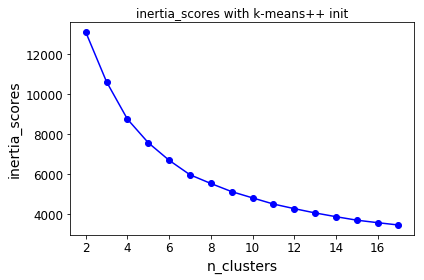

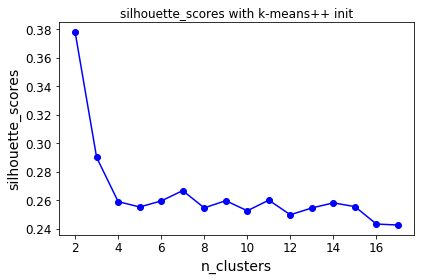

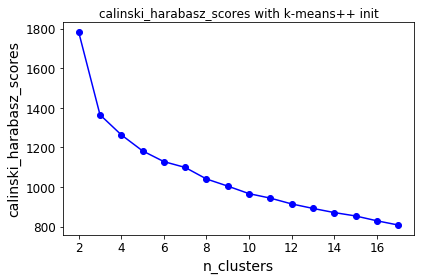

In [67]:
plot_scores('k-means++', 18, data, labels)

Saving figure inertia with random
Saving figure silhouette with random
Saving figure calinski_harabasz with random


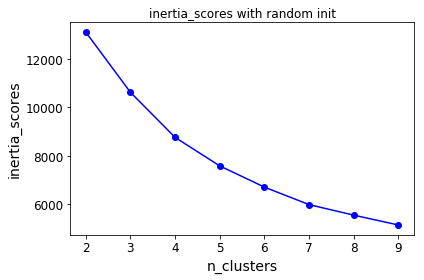

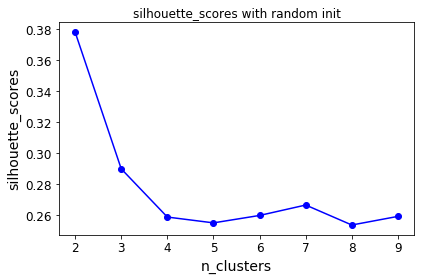

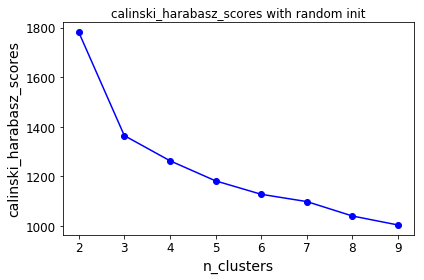

In [68]:
plot_scores('random', 10, data, labels)

In [29]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter

def plot_silhouette_diagram(clusterer, X, show_xlabels=True,
                            show_ylabels=True, show_title=True):
    """
    画轮廓图表
    
    :param clusterer: 训练好的聚类模型（这里是能提前设置簇数量的，可以稍微修改代码换成不能提前设置的）
    :param X: 只含特征的数据集
    :param show_xlabels: 为真，添加横坐标信息
    :param show_ylabels: 为真，添加纵坐标信息
    :param show_title: 为真，添加图表名
    """
    
    y_pred = clusterer.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_average = silhouette_score(X, y_pred)
    
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(clusterer.n_clusters):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / clusterer.n_clusters)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    
    plt.axvline(x=silhouette_average, color="red", linestyle="--")
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(clusterer.n_clusters)))
    
    if show_xlabels:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("Cluster")
    if show_title:
        plt.title("init:{}  n_cluster:{}".format(clusterer.init, clusterer.n_clusters))

Saving figure silhouette_diagram


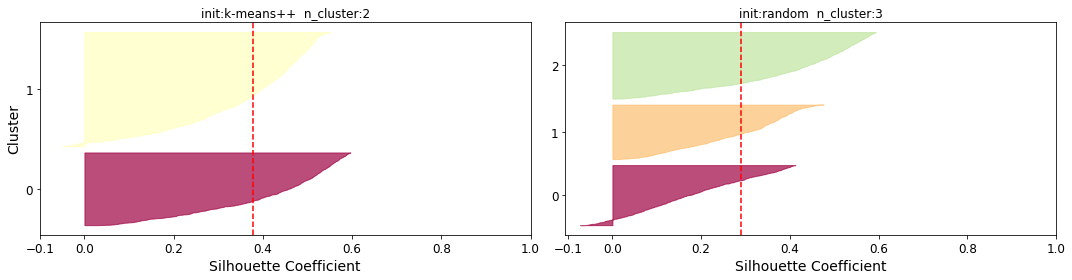

In [31]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_silhouette_diagram(km1, data)
plt.subplot(122)
plot_silhouette_diagram(km3, data, show_ylabels=False)
save_fig("silhouette_diagram")

# MiniBatch KMeans

In [32]:
from sklearn.cluster import MiniBatchKMeans

In [33]:
# 测试KMeans算法运行速度
%timeit KMeans(n_clusters=3).fit(data)

102 ms ± 6.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
# 测试MiniBatchKMeans算法运行速度
%timeit MiniBatchKMeans(n_clusters=5).fit(data)

26.8 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r Training: {}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans.fit(data)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(data)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

 Training: 100/100

Saving figure minibatch_kmeans_vs_kmeans


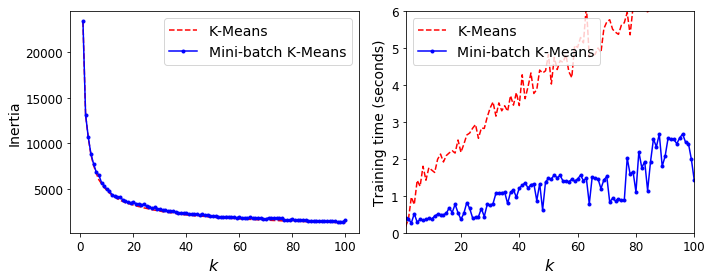

In [45]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.ylabel("Inertia", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.ylabel("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])
plt.legend(fontsize=14)

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

# 降维后聚类

In [46]:
from sklearn.decomposition import PCA

# 使用普通PCA进行降维，将特征从11维降至3维
pca1 = PCA(n_components=n_labels)
pca1.fit(data)

km4 = KMeans(init=pca1.components_, n_clusters=n_labels, n_init=10)
get_marks(km4, data, name="PCA-based KMeans", kmeans=True)

******************** PCA-based KMeans ********************
Mean Inertia Score:  10618.402509379326
Homogeneity Score:  0.044898784228055495
Completeness Score:  0.03594204734710607
V Measure Score:  0.03992423623331697
Adjusted Rand Score:  0.04418121532369815
Adjusted Mutual Info Score:  0.03516550164974287
Calinski Harabasz Score:  1364.4985488323168
Silhouette Score:  0.2909828000505603


/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [47]:
# 查看训练集的维度，已降至3个维度
len(pca1.components_)

3

In [48]:
# 使用普通PCA降维，将特征降至2维，作二维平面可视化
pca2 = PCA(n_components=2)
reduced_data = pca2.fit_transform(data)
# 使用k-means进行聚类，设置簇=3，初始化方法为'k-means++'
kmeans1 = KMeans(init="k-means++", n_clusters=3, n_init=3)
kmeans2 = KMeans(init="random", n_clusters=3, n_init=3)
kmeans1.fit(reduced_data)
kmeans2.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=3, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [49]:
# 训练集的特征维度降至2维
len(pca2.components_)

2

In [50]:
# 2维的特征值（降维后）
reduced_data

array([[ 4.45153748, -0.03328737],
       [-1.54165779, -0.33800428],
       [ 5.49714982, -0.03788792],
       ...,
       [-2.83761386,  1.57425341],
       [-3.10326034,  0.81236796],
       [-4.07764588,  2.46228071]])

In [51]:
# 3个簇中心的坐标
kmeans1.cluster_centers_

array([[-1.32936439, -1.20306107],
       [ 2.76207284,  0.06767564],
       [-1.98573882,  1.36787316]])

In [104]:
from matplotlib.colors import ListedColormap

def plot_data(X, real_tag=None):
    """
    画散点图
    
    :param X: 只含特征值的数据集 
    :param real_tag: 有值，则给含有不同分类的散点上色
    """
    try:
        if not real_tag:
            plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    except ValueError:
        types = list(np.unique(real_tag))
        for i in range(len(types)):
            plt.plot(X[:, 0][real_tag==types[i]], X[:, 1][real_tag==types[i]],
                     '.', label="{}".format(types[i]), markersize=3)
            plt.legend()

def plot_centroids(centroids, circle_color='w', cross_color='k'):
    """
    画出簇中心
    
    :param centroids: 簇中心坐标
    :param circle_color: 圆圈的颜色
    :param cross_color: 叉的颜色
    """
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, zorder=10, linewidths=8,
                color=circle_color, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, zorder=11, linewidths=50,
                color=cross_color, alpha=1)

def plot_centroids_labels(clusterer):
    labels = np.unique(clusterer.labels_)
    centroids = clusterer.cluster_centers_
    for i in range(centroids.shape[0]):
        t = str(labels[i])
        plt.text(centroids[i, 0]-1, centroids[i, 1]-1, t, fontsize=25,
                 zorder=10, bbox=dict(boxstyle='round', fc='yellow', alpha=0.5))
    
def plot_decision_boundaried(clusterer, X, tag=None, resolution=1000, 
                             show_centroids=True, show_xlabels=True,
                             show_ylabels=True, show_title=True,
                             show_centroids_labels=False):
    """
    画出决策边界，并填色
    
    :param clusterer: 训练好的聚类模型（能提前设置簇中心数量或不能提前设置都可以）
    :param X: 只含特征值的数据集
    :param tag: 只含真实分类信息的数据集，有值，则给散点上色
    :param resolution: 类似图片分辨率，给最小的单位上色
    :param show_centroids: 为真，画出簇中心
    :param show_centroids_labels: 为真，标注出该簇中心的标签
    """
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 可用color code或者color自定义填充颜色
    # custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap="Pastel2")
    plt.contour(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 colors='k')
    
    try:
        if not tag:
            plot_data(X)
    except ValueError:
        plot_data(X, real_tag=tag)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_centroids_labels:
        plot_centroids_labels(clusterer)
    if show_xlabels:
        plt.xlabel(r"$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    if show_title:
        plt.title("init:{}  n_cluster:{}".format(clusterer.init, clusterer.n_clusters))

Saving figure real_tag_vs_non


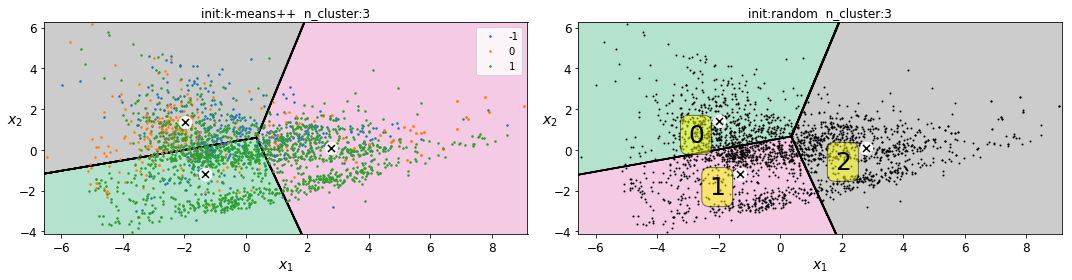

In [105]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_decision_boundaried(kmeans1, reduced_data, tag=labels)
plt.subplot(122)
plot_decision_boundaried(kmeans2, reduced_data, show_centroids_labels=True)
save_fig("real_tag_vs_non")
plt.show()

In [106]:
kmeans3 = KMeans(init="k-means++", n_clusters=3, n_init=3)
kmeans4 = KMeans(init="k-means++", n_clusters=4, n_init=3)
kmeans5 = KMeans(init="k-means++", n_clusters=5, n_init=3)
kmeans6 = KMeans(init="k-means++", n_clusters=6, n_init=3)

kmeans3.fit(reduced_data)
kmeans4.fit(reduced_data)
kmeans5.fit(reduced_data)
kmeans6.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=3, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Saving figure reduced_and_cluster


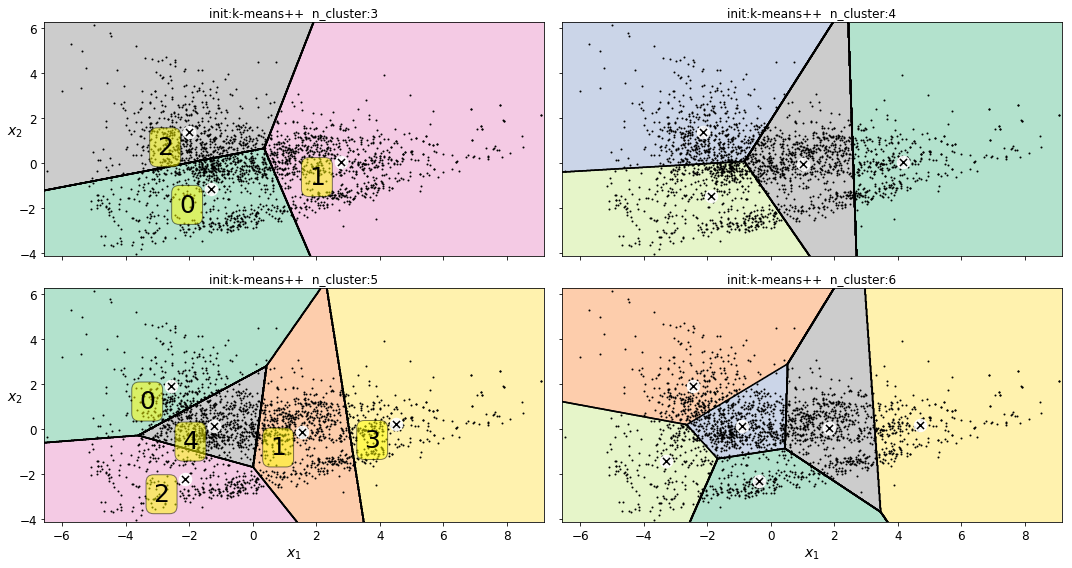

In [111]:
plt.figure(figsize=(15, 8))
plt.subplot(221)
plot_decision_boundaried(kmeans3, reduced_data, show_xlabels=False, show_centroids_labels=True)
plt.subplot(222)
plot_decision_boundaried(kmeans4, reduced_data, show_ylabels=False, show_xlabels=False)
plt.subplot(223)
plot_decision_boundaried(kmeans5, reduced_data, show_centroids_labels=True)
plt.subplot(224)
plot_decision_boundaried(kmeans6, reduced_data, show_ylabels=False)
save_fig("reduced_and_cluster")
plt.show()

# AP算法聚类

In [56]:
from sklearn.cluster import AffinityPropagation

# 使用AP聚类算法
af = AffinityPropagation(preference=-500, damping=0.8)
af.fit(data)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.8, max_iter=200, preference=-500, verbose=False)

In [57]:
# 获取簇的坐标
cluster_centers_indices = af.cluster_centers_indices_
cluster_centers_indices

array([ 415,  877,  978, 1430, 1446, 1609, 1890, 2246])

In [58]:
# 获取分类的类别数量
af_labels = af.labels_
np.unique(af_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [59]:
get_marks(af, data=data, af=True)

******************** None ********************
The estimated number of clusters:  8
Homogeneity Score:  0.12856452303045612
Completeness Score:  0.05715983518747723
V Measure Score:  0.07913584430055559
Adjusted Rand Score:  0.030229435212232002
Adjusted Mutual Info Score:  0.05567741585725629
Calinski Harabasz Score:  991.5024239771674
Silhouette Score:  0.23779642413811647


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [60]:
# 将AP聚类聚类的结果写入原始表格中
df['ap_clustering_label'] = af.labels_
# 以csv形式导出原始表格
df.to_csv('test2_result.csv')

In [61]:
# 最后两列为两种聚类算法的分类信息
df

,TRUE VALUE,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %),km_clustering_label,ap_clustering_label
0,1,47.60400,2.85800,5.74900,0.06200,7.02400,0.08700,12.62500,22.91600,0.32800,0.207900,6.174956e-02,0,7
1,1,51.78800,1.16600,2.55700,0.47500,6.80100,0.14500,14.76200,21.74300,0.32700,0.080071,1.488074e-02,1,6
2,1,46.56100,3.10900,6.13900,0.14500,6.91400,0.03700,12.47800,23.11200,0.62000,0.238984,2.320397e-02,0,7
3,1,46.34400,3.17000,7.77600,0.01400,6.84200,0.06800,11.68800,23.06700,0.57400,0.258931,4.970253e-02,0,7
4,1,50.18000,1.96500,3.29400,0.10600,5.72900,0.06300,13.60300,23.62600,0.54000,0.121500,1.933272e-02,0,0
5,-1,51.29200,0.98200,3.57300,0.60200,7.12100,0.10900,16.06400,19.34900,0.31200,0.101795,1.208946e-02,1,2
6,1,47.87100,2.55600,4.50300,0.01200,6.98700,0.06000,12.61100,23.63300,0.51000,0.183700,3.454924e-02,0,1
7,1,52.85500,1.03500,1.52300,0.94700,3.67300,0.06900,15.87000,23.19800,0.37100,0.055883,3.597478e-03,1,5
8,1,48.45500,1.85100,5.68400,0.40800,6.66800,0.07100,14.51400,21.55100,0.25900,0.192407,1.497884e-02,0,4
9,1,53.58000,0.66000,1.77000,0.24000,5.12000,0.06200,16.64000,21.89000,0.22000,0.044886,5.500000e-02,1,5


In [282]:
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RamdomizedSearchCV

# 使用GridSearchCV自动寻找最优参数，如果时间太久(约4.7min)，可以使用随机搜索
params = {'preference':[-50, -100, -150, -200], 'damping':[0.5, 0.6, 0.7, 0.8, 0.9]}
cluster = AffinityPropagation()
af_best_model = GridSearchCV(cluster, params, cv=5, scoring='adjusted_rand_score', verbose=1, n_jobs=-1)
af_best_model.fit(data, labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AffinityPropagation(affinity='euclidean',
                                           convergence_iter=15, copy=True,
                                           damping=0.5, max_iter=200,
                                           preference=None, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'preference': [-50, -100, -150, -200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='adjusted_rand_score', verbose=1)

In [304]:
# 最优模型的参数设置
af_best_model.best_params_

{'damping': 0.9, 'preference': -200}

In [305]:
# 最优模型的评分，使用调整的兰德系数(adjusted_rand_score)作为评分
af_best_model.best_score_

0.5508380887418878

In [306]:
# 获取最优模型
af1 = af_best_model.best_estimator_
af1

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.9, max_iter=200, preference=-200, verbose=False)

In [307]:
# 最优模型的评分
get_marks(af1, data=data, af=True)

******************** None ********************
The estimated number of clusters:  13
Homogeneity Score:  0.19636511123270978
Completeness Score:  0.07227434825460508
V Measure Score:  0.10565953684817687
Adjusted Rand Score:  0.0217109100126256
Adjusted Mutual Info Score:  0.07019308094388693
Calinski Harabasz Score:  1170.427954350586
Silhouette Score:  0.326437311078239


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [308]:
from sklearn.externals import joblib

# 保存以pkl格式最优模型
joblib.dump(af1, "af1.pkl")

['af1.pkl']

In [309]:
# 从pkl格式中导出最优模型
my_model_loaded = joblib.load("af1.pkl")

In [312]:
my_model_loaded

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.9, max_iter=200, preference=-200, verbose=False)

In [310]:
from sklearn.decomposition import PCA

# 使用普通PCA进行降维，将特征从11维降至3维
pca3 = PCA(n_components=n_labels)
reduced_data = pca3.fit_transform(data)

af2 = AffinityPropagation(preference=-200, damping=0.8)
get_marks(af2, reduced_data, name="PCA-based AF", af=True)

******************** PCA-based AF ********************
The estimated number of clusters:  12
Homogeneity Score:  0.12439793780217322
Completeness Score:  0.045921924344911644
V Measure Score:  0.06708075753937777
Adjusted Rand Score:  0.0071218807609881645
Adjusted Mutual Info Score:  0.04395651356635749
Calinski Harabasz Score:  2619.0959565547473
Silhouette Score:  0.4434019789730491


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


# 基于聚类结果的分层抽样

In [62]:
# data2是去掉真实分类信息的数据集（含有聚类后的结果）
data2 = df.drop("TRUE VALUE", axis=1)
data2

,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %),km_clustering_label,ap_clustering_label
0,47.60400,2.85800,5.74900,0.06200,7.02400,0.08700,12.62500,22.91600,0.32800,0.207900,6.174956e-02,0,7
1,51.78800,1.16600,2.55700,0.47500,6.80100,0.14500,14.76200,21.74300,0.32700,0.080071,1.488074e-02,1,6
2,46.56100,3.10900,6.13900,0.14500,6.91400,0.03700,12.47800,23.11200,0.62000,0.238984,2.320397e-02,0,7
3,46.34400,3.17000,7.77600,0.01400,6.84200,0.06800,11.68800,23.06700,0.57400,0.258931,4.970253e-02,0,7
4,50.18000,1.96500,3.29400,0.10600,5.72900,0.06300,13.60300,23.62600,0.54000,0.121500,1.933272e-02,0,0
5,51.29200,0.98200,3.57300,0.60200,7.12100,0.10900,16.06400,19.34900,0.31200,0.101795,1.208946e-02,1,2
6,47.87100,2.55600,4.50300,0.01200,6.98700,0.06000,12.61100,23.63300,0.51000,0.183700,3.454924e-02,0,1
7,52.85500,1.03500,1.52300,0.94700,3.67300,0.06900,15.87000,23.19800,0.37100,0.055883,3.597478e-03,1,5
8,48.45500,1.85100,5.68400,0.40800,6.66800,0.07100,14.51400,21.55100,0.25900,0.192407,1.497884e-02,0,4
9,53.58000,0.66000,1.77000,0.24000,5.12000,0.06200,16.64000,21.89000,0.22000,0.044886,5.500000e-02,1,5


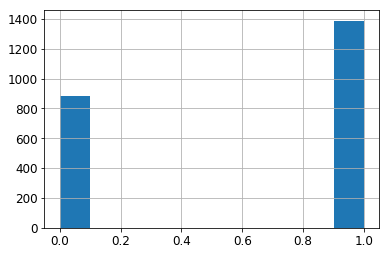

In [63]:
# 查看使用kmeans聚类后的分类标签值，两类
data2['km_clustering_label'].hist()

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit

# 基于kmeans聚类结果的分层抽样
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data2, data2["km_clustering_label"]):
    strat_train_set = data2.loc[train_index]
    strat_test_set = data2.loc[test_index]

In [65]:
def clustering_result_propotions(data):
    """
    分层抽样后，训练集或测试集里不同分类标签的数量比
    :param data: 训练集或测试集，纯随机取样或分层取样
    """
    return data["km_clustering_label"].value_counts() / len(data)

In [108]:
# 经过分层抽样的测试集中，不同分类标签的数量比
clustering_result_propotions(strat_test_set)

1    0.610989
0    0.389011
Name: km_clustering_label, dtype: float64

In [109]:
# 经过分层抽样的训练集中，不同分类标签的数量比
clustering_result_propotions(strat_train_set)

1    0.610897
0    0.389103
Name: km_clustering_label, dtype: float64

In [110]:
# 完整的数据集中，不同分类标签的数量比
clustering_result_propotions(data2)

1    0.610915
0    0.389085
Name: km_clustering_label, dtype: float64

In [106]:
from sklearn.model_selection import train_test_split

# 纯随机取样
random_train_set, random_test_set = train_test_split(data2, test_size=0.2, random_state=42)

# 完整的数据集、分层抽样后的测试集、纯随机抽样后的测试集中，不同分类标签的数量比
compare_props = pd.DataFrame({
    "Overall": clustering_result_propotions(data2),
    "Stratified": clustering_result_propotions(strat_test_set),
    "Random": clustering_result_propotions(random_test_set),
}).sort_index()

# 计算分层抽样和纯随机抽样后的测试集中不同分类标签的数量比，和完整的数据集中不同分类标签的数量比的误差
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Start. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Start. %error
0,0.389085,0.389011,0.382418,-1.713490,-0.018895
1,0.610915,0.610989,0.617582,1.091301,0.012034


In [328]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def get_classification_marks(model, data, labels, train_index, test_index):
    """
    获取分类模型（二元或多元分类器）的评分：F1值
    :param data: 只含有特征值的数据集
    :param labels: 只含有标签值的数据集
    :param train_index: 分层抽样获取的训练集中数据的索引
    :param test_index: 分层抽样获取的测试集中数据的索引
    :return: F1评分值
    """
    m = model(random_state=42)
    m.fit(data.loc[train_index], labels.loc[train_index])
    test_labels_predict = m.predict(data.loc[test_index])
    score = f1_score(labels.loc[test_index], test_labels_predict, average="weighted")
    return score

In [330]:
# 用分层抽样后的训练集训练分类模型后的评分值
start_marks = get_classification_marks(LogisticRegression, data, labels, strat_train_set.index, strat_test_set.index)
start_marks

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.709029771874991

In [331]:
# 用纯随机抽样后的训练集训练分类模型后的评分值
random_marks = get_classification_marks(LogisticRegression, data, labels, random_train_set.index, random_test_set.index)
random_marks

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7059927589215087

In [248]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.base import clone

# 分类模型
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)

# 基于分层抽样的k折交叉验证
skfolds = StratifiedKFold(n_splits=5, random_state=42)

# 储存每折测试集的模型评分
score_list = []

for train_index, test_index in skfolds.split(data2, data2["km_clustering_label"]):
    clone_clf = clone(sgd_clf)
    strat_X_train_folds = data.loc[train_index]
    strat_y_train_folds = labels.loc[train_index]
    strat_X_test_fold = data.loc[test_index]
    strat_y_test_fold = labels.loc[test_index]
    
    clone_clf.fit(strat_X_train_folds, strat_y_train_folds)
    test_labels_pred = clone_clf.predict(strat_X_test_fold)
    score = f1_score(labels.loc[test_index], test_labels_pred, average="weighted")
    
    score_list.append(score)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [249]:
# 每折测试集的模型评分
score_list

[0.751211138417513,
 0.6227780418250951,
 0.12935004693798663,
 0.536341797966456,
 0.09408178282350468]

In [252]:
np.array(score_list).mean()

0.42675256159411107

In [253]:
np.array(score_list).std()

0.26639341601261735

In [417]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone, BaseEstimator, TransformerMixin

class stratified_cross_val_score(BaseEstimator):
    """实现基于分层抽样的k折交叉验证"""
    
    def __init__(self, model, data, labels, random_state=0, cv=5):
        """
        :model: 训练的模型（回归或分类）
        :data: 只含特征值的完整数据集
        :labels: 只含标签值的完整数据集
        :random_state: 模型的随机种子值
        :cv: 交叉验证的次数
        """
        self.model = model
        self.data = data
        self.labels = labels
        self.random_state = random_state
        self.cv = cv
        self.score = []  # 储存每折测试集的模型评分
        self.i = 0            
    
    def fit(self, X, y):
        """
        :param X: 含有特征值和聚类结果的完整数据集
        :param y: 含有聚类结果的完整数据集
        :return: 每一折交叉验证的评分
        """
        skfolds = StratifiedKFold(n_splits=self.cv, random_state=self.random_state)

        for train_index, test_index in skfolds.split(X, y):
            # 复制要训练的模型（分类或回归）
            clone_model = clone(self.model)
            strat_X_train_folds = self.data.loc[train_index]
            strat_y_train_folds = self.labels.loc[train_index]
            strat_X_test_fold = self.data.loc[test_index]
            strat_y_test_fold = self.labels.loc[test_index]
            
            # 训练模型
            clone_model.fit(strat_X_train_folds, strat_y_train_folds)
            # 预测值（这里是分类模型的分类结果）
            test_labels_pred = clone_model.predict(strat_X_test_fold)
            
            # 这里使用的是分类模型用的F1值，如果是回归模型可以换成相应的模型
            score_fold = f1_score(labels.loc[test_index], test_labels_pred, average="weighted")
            
            # 避免重复向列表里重复添加值
            if self.i < self.cv:
                self.score.append(score_fold)
            else:
                None
                
            self.i += 1
        
        return self.score
    
    def transform(self, X, y=None):
        return self

    def mean(self):
        """返回交叉验证评分的平均值"""
        return np.array(self.score).mean()
    
    def std(self):
        """返回交叉验证评分的标准差"""
        return np.array(self.score).std()

In [418]:
from sklearn.linear_model import SGDClassifier

# 分类模型
clf_model = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
# 基于分层抽样的交叉验证，data是只含特征值的完整数据集，labels是只含标签值的完整数据集
clf_cross_val = stratified_cross_val_score(test_model, data, labels, cv=5, random_state=42)

In [419]:
# data2是含有特征值和聚类结果的完整数据集
clf_cross_val_score = clf_cross_val.fit(data2, data2["km_clustering_label"])

# 每折交叉验证的评分
clf_cross_val.score

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.751211138417513,
 0.6227780418250951,
 0.12935004693798663,
 0.536341797966456,
 0.09408178282350468]

In [420]:
# 交叉验证评分的平均值
clf_cross_val.mean()

0.42675256159411107

In [421]:
# 交叉验证评分的标准差
clf_cross_val.std()

0.26639341601261735